# A simple neural network to predict restaurant rating based on name

I used a gensim pre-trained word2vec model (GoogleNews-vectors-negative300) and some of its words' embeddings (most frequent 18000, to reduce model size), together with a corpus of 9000 London restaurant names and ratings, to train a simple LSTM model that predicts a restaurant's ratings based on its name.

The model is composed of an embedding later (pre-trained), a simple LSTM layer, a dropout layer, and a dense layer.

The performance is ok (given that restaurant names aren't typically very predictive of their performance ... this project is mostly for fun).

## Environment and load data

In [1]:
# !pip install gensim
# !pip install tensorflowjs

In [2]:
import re
import json
import random
import numpy as np
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflowjs
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

Load the gensim word embedding model.

In [3]:
word2vec_model = "GoogleNews-vectors-negative300.bin.gz"

w2v = KeyedVectors.load_word2vec_format(word2vec_model,binary=True)

print("Loaded Word2Vec with vocab size:", len(w2v.index_to_key))

Loaded Word2Vec with vocab size: 3000000


Load the restaurant names and ratings

In [4]:
df1 = pd.read_csv("london_restaurants.csv")
df2 = pd.read_csv("additional.csv")

df = pd.concat([df1, df2], ignore_index=True)
df = df.dropna(subset=["rating"])
print(df[:5])

                       name  price_level  rating  user_ratings_total  \
0           The Seven Stars          2.0     4.5               473.0   
1         The Ripley Anchor          3.0     4.4               435.0   
2  The Jovial Sailor Ripley          2.0     4.3              1536.0   
3        Cafe Beirut Ripley          NaN     4.4               142.0   
4               Onslow Arms          2.0     4.6              3090.0   

                                   website  \
0       https://thesevenstarsripley.co.uk/   
1           http://www.ripleyanchor.co.uk/   
2  http://www.baronspubs.com/jovialsailor/   
3                                      NaN   
4      http://www.onslowarmsclandon.co.uk/   

                                             address  postcode  
0             Newark Ln, Ripley, Woking GU23 6DL, UK  GU23 6DL  
1               High St, Ripley, Woking GU23 6AE, UK  GU23 6AE  
2  Portsmouth Road Ripley, Woking, Ripley, Woking...  GU23 6EZ  
3  1-2, London House, High St,

Preprocess the text:
- normalise to unicode (e.g. é to e)
- remove non-alphanumeric characters

In [5]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove accents
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("utf-8")

    # Remove non-alphanumeric characters
    text = re.sub(r"[^a-z0-9\s]", "", text)

    return text.split()

df["tokens"] = df["name"].apply(normalize_text)
print(df['tokens'][:5])

0              [the, seven, stars]
1            [the, ripley, anchor]
2    [the, jovial, sailor, ripley]
3           [cafe, beirut, ripley]
4                   [onslow, arms]
Name: tokens, dtype: object


In [6]:
corpus_vocab = set()

for tokens in df["tokens"]:
    corpus_vocab.update(tokens)

print("Corpus vocab size:", len(corpus_vocab))
# print(corpus_vocab)
# print("Malatang in vocab:", "malatang" in corpus_vocab)
# print("Hotpot in vocab:", "hotpot" in corpus_vocab)
# print("Hailidao in vocab:", "haidilao" in corpus_vocab)

Corpus vocab size: 6748


## Create training data and validation data

Retrieve the most frequent 8000 words in the glove embedding model (this is to make sure the final model is small enough).

In [7]:
# not exactly sure whether the words in this model is ordered by frequency ... but looks close enough

# top_word2vec_words = set(w2v.index_to_key[:18000])
print("Head of corpus: ", w2v.index_to_key[:20])
print("Tail of most frequent 18000: ", w2v.index_to_key[17980:18000])

# The word2vec model was case sensitive
top_word2vec_words = set()
n = 0
while len(top_word2vec_words) <= 18000:
  top_word2vec_words.add(w2v.index_to_key[n].lower())
  n += 1

final_vocab = corpus_vocab.union(top_word2vec_words)
print("Final vocab size:", len(final_vocab))

Head of corpus:  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are']
Tail of most frequent 18000:  ['Homer', 'consequently', 'surrendering', 'Billboard', 'swaps', 'bind', 'Gilmore', 'Oval_Office', 'Evansville', 'worms', 'underage', 'freezer', 'Houston_Astros', 'inefficient', 'Performing_Arts', 'Colleen', 'expressly_prohibited_without', 'token', 'Hobbs', 'suicide_bombing']
Final vocab size: 23119


I want to use this network for a fun application where people can input their restaurant's name and the algorithm predicts how well their restaurant will do. Since it might be common to name a restaurant with someone's name, here I make sure some of the most common names are in the word list.

In [8]:
names = []
with open("female.txt", "r") as f1:
  female_names = f1.read().lower().split('\n')
  names += female_names

with open("male.txt", "r") as f2:
  male_names = f2.read().lower().split('\n')
  names += male_names

# remove empty strings
names = [n for n in names if len(n)>0]

# add to word list
final_vocab = final_vocab.union(names)

print("Common names: ", names[:10], names[-10:])
print("Final vocab size:", len(final_vocab))

Common names:  ['abagael', 'abagail', 'abbe', 'abbey', 'abbi', 'abbie', 'abby', 'abigael', 'abigail', 'abigale'] ['zed', 'zedekiah', 'zeke', 'zelig', 'zerk', 'zeus', 'zippy', 'zollie', 'zolly', 'zorro']
Final vocab size: 29298


Save a corpus of words that are in the top 18000 but never appeared as restaurant names, for the next steps of simulating data.

In [9]:
ex_words = [w for w in top_word2vec_words if w not in corpus_vocab and w not in names]

print("Difference:", len(ex_words))
print("Example non-restaurant words: ", ex_words[:50])

Difference: 15425
Example non-restaurant words:  ['gloom', 'postings', 'employ', 'africans', 'solidly', 'compel', 'spurt', 'marking', 'belt', 'reign', 'equivalent', 'footage', 'surveillance', 'weighted_average', 'winter_games', 'differences', 'chief_executive_officer', 'disagreed', 'ethiopia', 'headlines', 'baskets', 'collective_bargaining', 'fcc', 'standards', 'sleep', 'raids', 'dismiss', 'varied', 'pointers', 'bearish', 'praising', 'assurance', 'painter', 'batman', 'modi', 'mode', 'lifeline', 'penalty', 'ambitions', 'transportation_safety', 'kobe_bryant', 'devastated', 'mom', 'invited', 'practical', 'rebates', 'azerbaijan', 'mass', 'hazardous', 'handing']


Add to tokens \<PAD\> to use when the name's length is shorter than "standard" length when training the model; \<UNK\> for unknown words.

Then, create a word index that gives each unique word in the corpus an index.

In [10]:
word_index = {
    "<PAD>": 0,
    "<UNK>": 1
}

for word in final_vocab:
    word_index[word] = len(word_index)

vocab_size = len(word_index)
print("Total vocab size:", vocab_size)

Total vocab size: 29300


Create initial embedding matrix.

In [11]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Compute UNK vector (mean of word2vec vectors)
unk_vector = np.mean(
    [w2v[word] for word in w2v.index_to_key[:50000]],
    axis=0
)

# since all words in the final vocab are lower case, so in this step I additionally check if the upper case is in the w2v model (for names etc.)
for word, idx in word_index.items():
    if word in w2v:
        embedding_matrix[idx] = w2v[word]
    elif word[0].upper()+word[1:] in w2v:
        embedding_matrix[idx] = w2v[word[0].upper()+word[1:]]
        print(word)
    else:
        embedding_matrix[idx] = unk_vector

Streaming output truncated to the last 5000 lines.
corrine
dorking
elora
youngstown
gutierrez
marquette
linet
dannye
dimitry
tessy
nariko
tarrant
sashenka
gingrich
abrahams
schumer
azmar
frieda
deeanne
rheta
simas
dasha
henrys
lazare
polow
beckenham
tanzania
darelle
aurelia
torey
marciano
antonina
sodo
alexs
mikako
elysee
dimitrios
deana
sebastiano
brunhilda
hodges
dulci
gregorio
rocca
romola
whitaker
alyson
deanne
ceciley
hatfield
jeth
alexi
ivie
ark.
marylynne
elana
michaella
bonnee
hewett
gilani
kandace
windham
shara
vitalia
delphine
tommie
mcdermott
willamina
emogene
lorena
roxi
highgate
angelico
fidel
otello
lewisham
missie
catarina
corba
gaap
endeavour
laryssa
hertford
bartie
melitta
willette
karlen
hepburns
dido
prudy
harar
noam
emeline
ivett
noami
lelia
patton
loscar
marlene
marrissa
gretta
hashim
gino
adriaens
emil
papu
isador
emera
reeta
sherilyn
zenia
arvin
rosita
enya
lani
khin
leia
dolan
laurens
oleg
wilmar
felice
nevins
bessy
tomlin
cabrina
erbil
layalina
hubb
carie
mizu


### Create simulated data for non-restaurant-like names

One problem I believe with the model without this step is that the trainign data only have positive examples, whereas I want it to learn that if a name is too "non-restaurant-like" (e.g. computer), the restaurant should have a lower rating. But without data like this the model will predict something that's closer to the average rating for these names.

So I created this step to add a simulated dataset that containes words that are in the w2v set but not in the restaurant set and give them lower ratings (average rating - distance to average representation).

In [12]:
# get average restaurant ratings
ratings = df["rating"].values.astype("float32")

avg = sum(ratings)/len(ratings)
sd = np.std(ratings)

print("Mean rating of all restaurants in dataset: ", avg)
print("Standard deviation: ", sd)

Mean rating of all restaurants in dataset:  4.3736105
Standard deviation:  0.39121768


In [13]:
# get average restaurant representations
def compute_restaurant_centroid(df, embed_model):
    vectors = []

    for tokens in df["tokens"]:
        for word in tokens:
            if word in embed_model:
                vectors.append(embed_model[word])

    vectors = np.array(vectors)

    centroid = np.mean(vectors, axis=0)
    return centroid

restaurant_centroid = compute_restaurant_centroid(df, w2v)

In [14]:
# get data simulations
def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def generate_synthetic_data(ex_words, embed_model, centroid, average_rating, max_len=6, n_samples=1000):

    synthetic_sequences = []
    synthetic_ratings = []

    for _ in range(n_samples):
        words = random.sample(ex_words, random.randrange(1, max_len+1))

        vectors = [embed_model[w] for w in words if w in embed_model]
        if not vectors:
            continue

        seq_vector = np.mean(vectors, axis=0)
        dist = cosine_distance(seq_vector, centroid)

        # dist and ratings are not the same scale but in this case I find a simple subtraction results in an average of about 3.6 for non-restaurant names
        # which looks realistic enough
        rating = average_rating - dist

        synthetic_sequences.append(" ".join(words))
        synthetic_ratings.append(rating)

    df = pd.DataFrame({
        "name": synthetic_sequences,
        "rating": synthetic_ratings
    })

    df["tokens"] = df["name"].apply(normalize_text)

    return df

synthetic_df = generate_synthetic_data(ex_words, w2v, restaurant_centroid, avg, max_len=6, n_samples=1000)
print(synthetic_df[:5])
print("Average simulated ratings: ", sum(synthetic_df['rating'])/len(synthetic_df['rating']))

df_final = pd.concat([df, synthetic_df], ignore_index=True)
print(df_final[:5])
print(df_final[-5:])
print("Final data length: ", len(df_final))

                                                name    rating  \
0                                            destiny  3.504940   
1                     yahoo principle warmed delgado  3.703232   
2                                 clothing narrative  3.627597   
3              lousy commute mclean exhaustive kinds  3.636421   
4  rolls_royce ear cease_fire totally forecasting...  3.704140   

                                              tokens  
0                                          [destiny]  
1                [yahoo, principle, warmed, delgado]  
2                              [clothing, narrative]  
3        [lousy, commute, mclean, exhaustive, kinds]  
4  [rollsroyce, ear, ceasefire, totally, forecast...  
Average simulated ratings:  3.612711377713362
                       name  price_level  rating  user_ratings_total  \
0           The Seven Stars          2.0     4.5               473.0   
1         The Ripley Anchor          3.0     4.4               435.0   
2  The Jovi

The RNN requires each sample to be of equal length, which is not the case with restaurants. So use padding and truncating to normalize the length of samples. (add padding representations when sample is shorter, truncate when sample is longer).

In [15]:
max_len = 6

def encode(tokens):
    sequence = []
    for word in tokens:
        if word in word_index:
            sequence.append(word_index[word])
        else:
            sequence.append(word_index["<UNK>"])

    # pad or truncate
    sequence = sequence[:max_len]
    while len(sequence) < max_len:
        sequence.append(word_index["<PAD>"])

    return sequence


Create data. X = the words' embedding, y = log-transformed adjusted rating

In [16]:
X = np.array(df_final["tokens"].apply(encode).tolist())
y = df_final["rating"].values.astype("float32")

### Transform Y (rating) to deal with clustering

Restaurant ratings are closely clustered around the center (most restaurants are rated 4.3-4.5), so try to normalise score to improve model.

In [17]:
# use logit transformation
epsilon = 1e-5
y_scaled = (y - 1) / 4   # scale 1–5 scores to 0–1
y_scaled = np.clip(y_scaled, epsilon, 1 - epsilon)
y_transformed = np.log(y_scaled / (1 - y_scaled))

print(y[:50])
print(y_transformed[:50])

[4.5 4.4 4.3 4.4 4.6 4.7 4.6 4.7 4.6 4.2 4.5 4.7 4.7 4.5 4.5 4.4 4.5 4.4
 4.3 4.6 4.7 3.2 4.6 4.9 4.4 2.8 4.4 4.4 4.4 4.8 4.7 4.5 4.4 4.7 4.5 4.1
 4.9 4.6 4.7 2.6 4.2 4.6 4.3 4.7 4.6 4.7 4.7 4.8 4.5 4.3]
[ 1.9459102   1.7346013   1.5505978   1.7346013   2.1972244   2.5123048
  2.1972244   2.5123048   2.1972244   1.386294    1.9459102   2.5123048
  2.5123048   1.9459102   1.9459102   1.7346013   1.9459102   1.7346013
  1.5505978   2.1972244   2.5123048   0.20067078  2.1972244   3.6635625
  1.7346013  -0.2006708   1.7346013   1.7346013   1.7346013   2.94444
  2.5123048   1.9459102   1.7346013   2.5123048   1.9459102   1.2367625
  3.6635625   2.1972244   2.5123048  -0.4054652   1.386294    2.1972244
  1.5505978   2.5123048   2.1972244   2.5123048   2.5123048   2.94444
  1.9459102   1.5505978 ]


Logit transformation doesn't improve the model too much after some tries, so I decided to use centering (but aroung the real restaurant ratings rather than average with the simulated data).

In [18]:
# use centering
y_centered = y - avg

print(y[:50])
print(y_centered[:50])

print(y[-20:])
print(y_centered[-20:])

[4.5 4.4 4.3 4.4 4.6 4.7 4.6 4.7 4.6 4.2 4.5 4.7 4.7 4.5 4.5 4.4 4.5 4.4
 4.3 4.6 4.7 3.2 4.6 4.9 4.4 2.8 4.4 4.4 4.4 4.8 4.7 4.5 4.4 4.7 4.5 4.1
 4.9 4.6 4.7 2.6 4.2 4.6 4.3 4.7 4.6 4.7 4.7 4.8 4.5 4.3]
[ 0.1263895   0.0263896  -0.07361031  0.0263896   0.22638941  0.3263893
  0.22638941  0.3263893   0.22638941 -0.17361069  0.1263895   0.3263893
  0.3263893   0.1263895   0.1263895   0.0263896   0.1263895   0.0263896
 -0.07361031  0.22638941  0.3263893  -1.1736104   0.22638941  0.5263896
  0.0263896  -1.5736105   0.0263896   0.0263896   0.0263896   0.4263897
  0.3263893   0.1263895   0.0263896   0.3263893   0.1263895  -0.2736106
  0.5263896   0.22638941  0.3263893  -1.7736106  -0.17361069  0.22638941
 -0.07361031  0.3263893   0.22638941  0.3263893   0.3263893   0.4263897
  0.1263895  -0.07361031]
[3.71254   3.717835  3.6764035 3.5744534 3.6369283 3.584972  3.6422853
 3.4599156 3.6817915 3.5867822 3.4555922 3.7231793 3.4448082 3.718719
 3.443215  3.6438608 3.4498205 3.659801  3.470662  3

Split training set and validation set by 8:2

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_centered, test_size=0.2, random_state=5
)

## Implement model with tensorflow

Implement the model using tensorflow. I tried a few manipulations:
- 1 vs. 2 layers of LSTM
- 1 vs. 2 layers of dense
- trainable vs. untrainable embedding layer

In the end, I found that what worked the best was the simplest model, likely due to the small size of data and the short length of sequences:
- non-trainable embedding layer
- one layer of LSTM
- one layer of dropout
- one dence layer
- smaller learning rate (0.0001)

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_len,)),

    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False # can't really decide to use True or False, True seems to hurt model performance slightly, but I think true makes some sense since the words in the restaurant names but not in the w2v set were given the average embedding
    ),

    # tf.keras.layers.LSTM(64, return_sequences = True),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation="linear")
])

learning_rate = 0.0001  # default is 0.001, use lower since I have very few data
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 6, 300)         │     8,790,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        42,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,832,657 (33.69 MB)

 Trainable params: 42,657 (166.63 KB)

 Non-trainable params: 8,790,000 (33.53 MB)

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1946 - mae: 0.3406 - val_loss: 0.1872 - val_mae: 0.3338
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1826 - mae: 0.3290 - val_loss: 0.1783 - val_mae: 0.3282
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1639 - mae: 0.3140 - val_loss: 0.1714 - val_mae: 0.3230
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1553 - mae: 0.3072 - val_loss: 0.1662 - val_mae: 0.3137
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1520 - mae: 0.2991 - val_loss: 0.1628 - val_mae: 0.3068
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1517 - mae: 0.2978 - val_loss: 0.1621 - val_mae: 0.3104
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1415 - mae: 0.2865 - val_loss: 0.1585 - val_mae: 0.3020
Epoch 8/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1456 - mae: 0.2877 - val_loss: 0.1575 - val_mae: 0.2994
Epoch 9/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - l

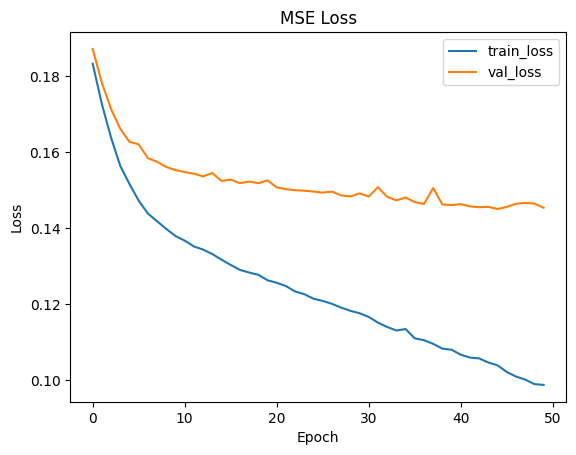

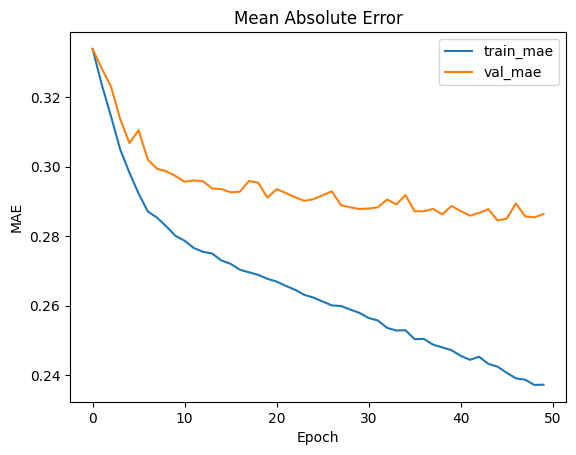

In [22]:
# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Save and test model predictions

Save the model in tensorflow keras format, tensorflow saved model format, then convert to tensorflow.js format

In [23]:
print(tf.version.VERSION)

model.save("restaurant_rating_model_w2v_20000.keras")
model.save("restaurant_rating_model_w2v_20000.h5")
model.export('saved_model_w2v_20000')

# Load model
#model = tf.keras.models.load_model("restaurant_rating_model_w2v_20000.keras")

# Check summary
# model.summary()

2.19.0
Saved artifact at 'saved_model_w2v_20000'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134297761665808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134297761669648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134297761668304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134297761670224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134297761665424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134297761670032: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [24]:
!tensorflowjs_converter --input_format=keras \
    --output_format=tfjs_layers_model \
    restaurant_rating_model_w2v_20000.h5 \
    tfjs_model_w2v_20000/

2026-02-20 10:48:17.020309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771584497.054422   20675 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771584497.063788   20675 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771584497.089314   20675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771584497.089428   20675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771584497.089434   20675 computation_placer.cc:177] computation placer alr

Save the word ids (this is different every time since words was created as a set not a list).

In [25]:
# Save
with open("word_index_w2v_20000.json", "w") as f:
    json.dump(word_index, f)

Implement prediction from model.
Add a penalty for unkown words (in case the user input random characters like asedhtioaoqw4).

In [26]:
# Load model
#model = tf.keras.models.load_model("restaurant_rating_model_w2v.keras")

# Check summary
# model.summary()

In [27]:
def predict_rating_with_penalty(name, model, word_index, max_len=6, unk_penalty=2):
    import unicodedata, re
    import numpy as np

    # Normalize text
    name = name.lower()
    name = unicodedata.normalize("NFKD", name)
    name = name.encode("ascii", "ignore").decode("utf-8")
    name = re.sub(r"[^a-z0-9\s]", "", name)
    tokens = name.split()

    # Encode tokens
    sequence = []
    unk_count = 0
    for word in tokens:
        if word in word_index:
            sequence.append(word_index[word])
        else:
            sequence.append(word_index["<UNK>"])
            print("unknown")
            unk_count += 1

    # Pad/truncate
    sequence = sequence[:max_len]
    while len(sequence) < max_len:
        sequence.append(word_index["<PAD>"])

    X_input = np.array([sequence], dtype="int32")

    # Predict
    # pred_scaled = model.predict(X_input, verbose=0)[0][0]
    # pred = 1 + 4 * (1 / (1 + np.exp(-pred_scaled)))  # inverse logit
    pred_centered = model.predict(X_input, verbose=0)[0][0]
    pred = pred_centered + avg

    # Apply penalty: pull prediction down for unknown words
    if unk_count > 0:
        penalty = unk_penalty * (unk_count / len(tokens))  # proportional to fraction of unknown words
        pred = pred - penalty

    # Clip to valid rating
    pred = np.clip(pred, 1, 5)
    return round(float(pred), 2)

In [28]:
new_name = input()
rating = predict_rating_with_penalty(new_name, model, word_index)
print(f"Predicted rating for '{new_name}': {rating}")

KFC
Predicted rating for 'KFC': 4.06


In [29]:
new_name = input()
rating = predict_rating_with_penalty(new_name, model, word_index)
print(f"Predicted rating for '{new_name}': {rating}")

lobster grill
Predicted rating for 'lobster grill': 4.49


In [30]:
new_name = input()
rating = predict_rating_with_penalty(new_name, model, word_index)
print(f"Predicted rating for '{new_name}': {rating}")

jason cafe
Predicted rating for 'jason cafe': 4.61


In [31]:
new_name = input()
rating = predict_rating_with_penalty(new_name, model, word_index)
print(f"Predicted rating for '{new_name}': {rating}")

computer cluster
Predicted rating for 'computer cluster': 3.86


In [32]:
new_name = input()
rating = predict_rating_with_penalty(new_name, model, word_index)
print(f"Predicted rating for '{new_name}': {rating}")

q23io895h
unknown
Predicted rating for 'q23io895h': 2.32
